In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [3]:
#Read In data
df_2020 = pd.read_csv('/content/play_by_play_2020.csv',low_memory=False)
df_2021 = pd.read_csv('/content/play_by_play_2021.csv',low_memory=False)
df_2022 = pd.read_csv('/content/play_by_play_2022.csv',low_memory=False)

In [4]:
#Combine the dataframes into one
df = pd.concat([df_2020,df_2021,df_2022],axis = 0)

In [5]:
#Feature Selection
features = ['posteam','posteam_type','defteam','yardline_100','qtr','quarter_seconds_remaining','down','ydstogo','shotgun','posteam_score','defteam_score','score_differential','play_type']

In [6]:
df = df[features]

In [7]:
df.head()

,posteam,posteam_type,defteam,yardline_100,qtr,quarter_seconds_remaining,down,ydstogo,shotgun,posteam_score,defteam_score,score_differential,play_type
0,NaN,NaN,NaN,NaN,1,900.0,NaN,0,0,NaN,NaN,NaN,NaN
1,SF,home,ARI,35.0,1,900.0,NaN,0,0,0.0,0.0,0.0,kickoff
2,SF,home,ARI,75.0,1,900.0,1.0,10,1,0.0,0.0,0.0,pass
3,SF,home,ARI,55.0,1,882.0,1.0,10,1,0.0,0.0,0.0,run
4,SF,home,ARI,41.0,1,839.0,1.0,10,0,0.0,0.0,0.0,run


# Data Cleaning

In [8]:
df.isnull().sum()

posteam                       5601
posteam_type                  5601
defteam                       5601
yardline_100                  6374
qtr                              0
quarter_seconds_remaining        8
down                         13089
ydstogo                          0
shotgun                          0
posteam_score                 5601
defteam_score                 5601
score_differential            5601
play_type                     3309
dtype: int64

In [9]:
#Since play_type is going to be our target variable, lets look into it
df[df['play_type'].isna()]

,posteam,posteam_type,defteam,yardline_100,qtr,quarter_seconds_remaining,down,ydstogo,shotgun,posteam_score,defteam_score,score_differential,play_type
0,NaN,NaN,NaN,NaN,1,900.0,NaN,0,0,NaN,NaN,NaN,NaN
44,SF,home,ARI,NaN,1,0.0,NaN,0,0,10.0,7.0,3.0,NaN
76,NaN,NaN,NaN,NaN,2,120.0,NaN,0,0,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,2,0.0,NaN,0,0,NaN,NaN,NaN,NaN
134,ARI,away,SF,NaN,3,0.0,NaN,0,0,10.0,13.0,-3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23621,NaN,NaN,NaN,NaN,1,900.0,NaN,0,0,NaN,NaN,NaN,NaN
23658,SEA,away,ARI,NaN,1,0.0,NaN,0,0,3.0,7.0,-4.0,NaN
23694,NaN,NaN,NaN,NaN,2,120.0,NaN,0,0,NaN,NaN,NaN,NaN
23710,NaN,NaN,NaN,NaN,2,0.0,NaN,0,0,NaN,NaN,NaN,NaN


In [11]:
#It looks like the play_type is nan when its the end of a quarter, half time, 2 minute warning, or a timeout
#so it's safe to drop these rows
df.dropna(subset = ['play_type'],inplace = True)

In [12]:
#Lets investigate more into our target variable
df['play_type'].value_counts()

pass           31145
run            21788
no_play         7011
kickoff         4357
punt            3174
extra_point     2016
field_goal      1599
qb_kneel         670
qb_spike         120
Name: play_type, dtype: int64

In [13]:
#Drop where play_type is no_play
df = df[df['play_type'] != 'no_play']

In [14]:
#Check
df['play_type'].value_counts()

pass           31145
run            21788
kickoff         4357
punt            3174
extra_point     2016
field_goal      1599
qb_kneel         670
qb_spike         120
Name: play_type, dtype: int64

In [15]:
#It looks like dropping play_type null values also dropped most of the nulls besides the down column
df.isnull().sum()

posteam                         0
posteam_type                    0
defteam                         0
yardline_100                    0
qtr                             0
quarter_seconds_remaining       0
down                         6601
ydstogo                         0
shotgun                         0
posteam_score                   0
defteam_score                   0
score_differential              0
play_type                       0
dtype: int64

In [16]:
#Check where down is null
df[df['down'].isna()]

,posteam,posteam_type,defteam,yardline_100,qtr,quarter_seconds_remaining,down,ydstogo,shotgun,posteam_score,defteam_score,score_differential,play_type
1,SF,home,ARI,35.0,1,900.0,NaN,0,0,0.0,0.0,0.0,kickoff
8,ARI,away,SF,35.0,1,710.0,NaN,0,0,0.0,3.0,-3.0,kickoff
16,SF,home,ARI,15.0,1,593.0,NaN,0,0,9.0,0.0,9.0,extra_point
17,ARI,away,SF,35.0,1,593.0,NaN,0,0,0.0,10.0,-10.0,kickoff
27,ARI,away,SF,15.0,1,415.0,NaN,0,0,6.0,10.0,-4.0,extra_point
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23765,SEA,away,ARI,15.0,4,452.0,NaN,0,0,23.0,14.0,9.0,extra_point
23766,ARI,home,SEA,35.0,4,452.0,NaN,0,0,14.0,24.0,-10.0,kickoff
23784,ARI,home,SEA,15.0,4,212.0,NaN,0,0,20.0,24.0,-4.0,extra_point
23786,SEA,away,ARI,35.0,4,212.0,NaN,0,0,24.0,21.0,3.0,kickoff


The values in the down column that are null are due to the play being a kickoff or extra_point, since we dont want those play_types, we can drop the null value rows.

In [18]:
#Drop the null values 
df.dropna(subset = ['down'],inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [19]:
df.isnull().sum()

posteam                      0
posteam_type                 0
defteam                      0
yardline_100                 0
qtr                          0
quarter_seconds_remaining    0
down                         0
ydstogo                      0
shotgun                      0
posteam_score                0
defteam_score                0
score_differential           0
play_type                    0
dtype: int64

In [54]:
#Create X and y
X = df.drop(columns = ['play_type','score_differential','shotgun'])
y = df['play_type']

In [55]:
#Create Baseline
y.value_counts(normalize=True)

pass          0.531767
run           0.372760
punt          0.054472
field_goal    0.027442
qb_kneel      0.011499
qb_spike      0.002059
Name: play_type, dtype: float64

In [56]:
# Transform the target variable into numerical values
le = LabelEncoder()
y_sc = le.fit_transform(y)

In [57]:
#Onehot Encode categorical features and scale numerical values
processor = ColumnTransformer([
    ('ohe',OneHotEncoder(),['posteam','posteam_type','defteam']),
    ('ss',StandardScaler(),['yardline_100','qtr','quarter_seconds_remaining','down','ydstogo','posteam_score','defteam_score'])
],remainder= 'passthrough')

In [58]:
#Fit and transform the processor
X_sc = processor.fit_transform(X)

In [59]:
#Train Test Split
X_train,X_test,y_train,y_test = train_test_split(X_sc,y_sc,random_state = 42, stratify = y ,shuffle = True)

In [60]:
#Principal Component Analysis to help reduce the dimensionality of our dataset
pca = PCA()

In [61]:
#Fit and transform the pca
Z_train= pca.fit_transform(X_train.todense())
Z_test = pca.transform(X_test.todense())

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [67]:
Z_train.shape

(43701, 73)

In [70]:
le.classes_

array(['field_goal', 'pass', 'punt', 'qb_kneel', 'qb_spike', 'run'],
      dtype=object)

In [105]:
es = EarlyStopping(patience = 20)

In [106]:
#Create a neural network containing regularizers and dropouts
model = Sequential()
model.add(Dense(8,
                activation = 'relu',
                input_shape = (73,)))
model.add(Dense(64, activation = 'relu',kernel_regularizer = l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
# Multi-Class Output layer
# 1 neuron PER class 
model.add(Dense(6, # 1 neuron per class
                activation = 'softmax')) # softmax activation for multi-class classification
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['acc'])


In [107]:
#Fit neural network model
h = model.fit(Z_train, y_train,
                epochs = 100,
                batch_size = 256,
                validation_data = (Z_test, y_test),
              callbacks = [es])

Epoch 1/100
171/171 [==============================] - 5s 15ms/step - loss: 1.1350 - acc: 0.5213 - val_loss: 0.9176 - val_acc: 0.5493
Epoch 2/100
171/171 [==============================] - 2s 10ms/step - loss: 0.8576 - acc: 0.5685 - val_loss: 0.7790 - val_acc: 0.6051
Epoch 3/100
171/171 [==============================] - 1s 9ms/step - loss: 0.7695 - acc: 0.6021 - val_loss: 0.7329 - val_acc: 0.6247
Epoch 4/100
171/171 [==============================] - 1s 8ms/step - loss: 0.7352 - acc: 0.6241 - val_loss: 0.7115 - val_acc: 0.6393
Epoch 5/100
171/171 [==============================] - 2s 9ms/step - loss: 0.7133 - acc: 0.6366 - val_loss: 0.6875 - val_acc: 0.6452
Epoch 6/100
171/171 [==============================] - 1s 9ms/step - loss: 0.6979 - acc: 0.6429 - val_loss: 0.6871 - val_acc: 0.6375
Epoch 7/100
171/171 [==============================] - 1s 8ms/step - loss: 0.6885 - acc: 0.6443 - val_loss: 0.6714 - val_acc: 0.6571
Epoch 8/100
171/171 [==============================] - 3s 16ms/step

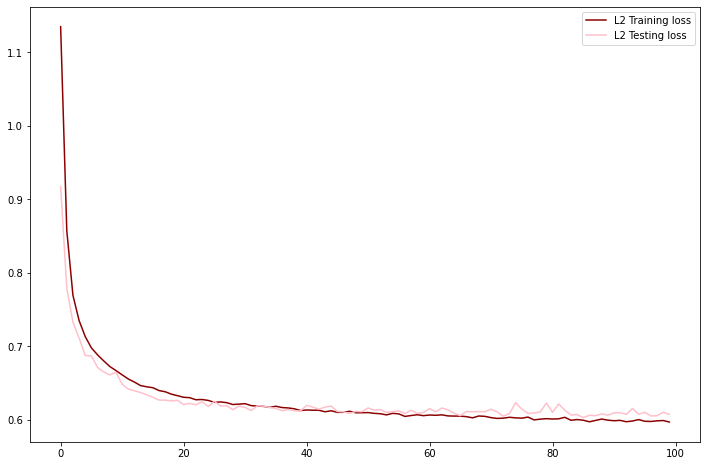

In [108]:
#Showcase the models loss over the epochs
train_loss = h.history['loss']
test_loss = h.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='L2 Training loss', color='darkred')
plt.plot(test_loss, label='L2 Testing loss', color='pink')
plt.legend();

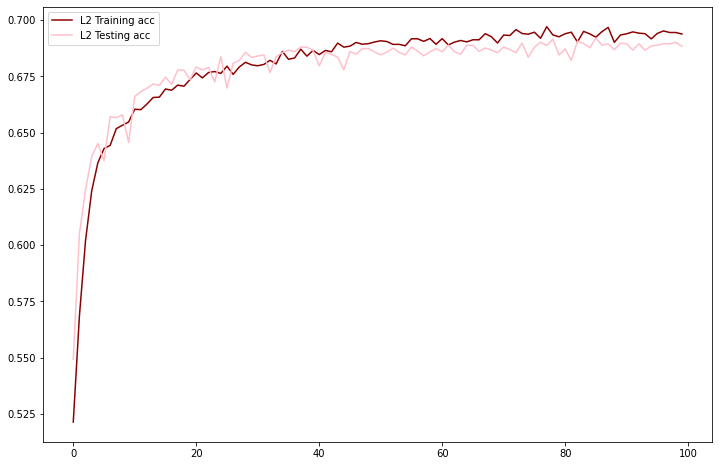

In [109]:
#Show case the accuracy metric over the epochs
train_acc = h.history['acc']
test_acc = h.history['val_acc']

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='L2 Training acc', color='darkred')
plt.plot(test_acc, label='L2 Testing acc', color='pink')
plt.legend();

As we can see by using a neural network it gets around the same score as when we used the xgboost model but slightly worse. Neural networks are better when it comes nontabulated data such as images, videos, speech recognition. Because of this we'll be going more into the model evaluations for the xgboost model instead of the neural network model.